Slight differences in Spice due to the muon template that was not included in my new iteration!!

Ftp slightly better, not sure why? Maybe also muontemplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os, glob
import pandas as pd
import numpy as np
import pickle

from matplotlib import ticker, cm, colors
from matplotlib.lines import Line2D
import matplotlib
import matplotlib.pyplot as plt

from scipy.interpolate import griddata as scipyGrid

from NNMFit.utilities import ScanHandler

# import plotting utils
sys.path.append( "/data/user/tvaneede/utils" )
from FlavourScansPlotting import get_contour_points, plot_confidence_intervals

In [3]:
# load and set matplotlib parameters
%matplotlib inline
import matplotlib as mpl
import matplotlib.font_manager as font_manager
rcParams = {"axes.titlesize": 16,"axes.labelsize": 14,"xtick.labelsize": 14,"ytick.labelsize": 14}
mpl.rcParams.update(rcParams)
font_axis_label = {'family': 'serif','color':  'black','weight': 'normal','size': 22}
font_title = {'family': 'serif','color':  'black','weight': 'bold','size': 20}
font_legend = font_manager.FontProperties(family='serif',weight='normal',style='normal', size=13)

In [4]:
# import scanning points
from flavor_fracs import *
points = pd.read_pickle('/data/user/tvaneede/GlobalFit/custom_scan_flavor/default_custom_scan_points_flavor.pickle')
flavs = flavor_frac(np.asarray(points['astro_nue_ratio']),np.asarray(points['astro_nutau_ratio']))

In [5]:
# triangle plotting settings
from Ternary import flavor_triangle
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.family':'serif'})

In [6]:
plotting_path = "/data/user/tvaneede/GlobalFit/reco_processing/NNMFit/notebooks/flavor_globalfit/compare_benchmark"
os.system(f"mkdir -p {plotting_path}")

0

In [ ]:
benchmark_path = "/data/user/tvaneede/GlobalFit/reco_processing/NNMFit/dag_scans/recreate_neha_benchmark/output"
flavor_globalfit_path = "/data/user/tvaneede/GlobalFit/reco_processing/NNMFit/dag_scans/flavor_globalfit/hese"

scan_dir_dict = {
"spice_benchmark"        : f"{benchmark_path}/asimov_SAY_HESEBestfit_NoSystematics", # with muon template
"ftp_benchmark"        : f"{benchmark_path}/taureco_v4_FinalTopology_muonTemplateTrack", # with muon template

"spice"        : f"{flavor_globalfit_path}/asimov_SAY_HESEBestfit_NoSystematics_spice", # both without muon template!!
"ftp"        : f"{flavor_globalfit_path}/asimov_SAY_HESEBestfit_NoSystematics_ftp_FinalTopology",
}

In [21]:
drop_unsuccessful = False
scan_dict = {}
for name, scan_dir in scan_dir_dict.items():
    print(name)
    scan_dict[name] = ScanHandler(scan_dir,dump=False,drop_unsuccessful=drop_unsuccessful)

In [22]:
data = {}
for name in scan_dict:
    # print(name)
    data[name] = {}
    data[name]["ftau_asimov_poisson"],data[name]["fe_asimov_poisson"],data[name]["ft_grid_asimov_poisson"],data[name]["fe_grid_asimov_poisson"],data[name]["ts_grid_asimov_poisson"] = get_contour_points(scan_dict,name)

removed stuff
removed stuff
removed stuff
removed stuff


In [10]:
ts_dict = {
    '68%' : 2.37,
    '90%' : 4.605,
    '95%' : 5.99,
}

In [11]:
colours = ["black","C0","C3","C2", "C1", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11"]
linestyles = ["-","--",":"]

In [12]:
# needed for area comparison!
C = {}

def compare_contours( names, labels, levels = ['68%'], title = r"HESE: $\phi_0 = 2.12,\gamma=2.87$",output_name = "test" ):

    fig = plt.figure()
    tax = flavor_triangle()

    lh, ll = [], []

    asimov = tax.ca.scatter([1.0/3], [1.0/3], marker='*', facecolor='black',
                    edgecolor='k', lw=0.5, s=80)
    lh.append(asimov)
    ll.append('Asimov: 1:1:1')

    fmt={} # set labels to the contours

    ts_values = [ts_dict[i] for i in levels]

    for i,name in enumerate(names):
        C[name] = tax.ca.contour(data[name]["ft_grid_asimov_poisson"],
                                data[name]["fe_grid_asimov_poisson"],
                                data[name]["ts_grid_asimov_poisson"], 
                                ts_values,
                                linestyles=linestyles[:len(levels)],
                                linewidths=1.5,
                                colors=colours[i])
        
        h, _ = C[name].legend_elements()
        lh.append(h[0]) # legend elements
        ll.append(labels[i])

        # add ts levels in plot
        if i == len(names) - 1:
            for l, s in zip(C[name].levels, levels):
                fmt[l] = s
            plt.clabel(C[name],ts_values,inline=True,fontsize=12.,
                    fmt=fmt,colors='black')

    l = fig.legend(lh,ll,
                    bbox_to_anchor=(0.7, 0.05),prop=font_legend,
                    ncols=1 if len(names) < 5 else 2,frameon=True,fancybox=True,shadow=True)
    if title: plt.title(title,y=1.1,fontdict=font_title)    

    plt.savefig(f"{plotting_path}/contour_{output_name}.pdf",bbox_inches='tight')

In [14]:
def polygon_area(x, y):
    # Close path if not already closed
    if x[0] != x[-1] or y[0] != y[-1]:
        x = np.append(x, x[0])
        y = np.append(y, y[0])
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def compare_area( alt_key, base_key, levels ):
    areas = {}

    ts_values = [ts_dict[i] for i in levels]

    for name in [alt_key,base_key]: 
        # print(f"Processing {name}")
        contour_obj = C[name]
        area_list = []
        for i, level in enumerate(levels):  # 68%, 90%
            paths = contour_obj.collections[i].get_paths()
            level_area = 0.0
            for p in paths:
                v = p.vertices
                x, y = v[:, 0], v[:, 1]
                level_area += polygon_area(x, y)
            area_list.append(level_area)
            # print(f"Area for level {ts_values[i]} ({level}): {level_area:.4f}")
        areas[name] = area_list

    # Now calculate and print ratio of areas at 68% CL (index 0) and 90% CL (index 1)
    for i, level in enumerate(levels):
        ratio = areas[alt_key][i] / areas[base_key][i]
        print(f"Area ratio ({alt_key} / {base_key}) at {level}: {ratio:.4f}")

/data/user/tvaneede/utils/Ternary.py:74: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.xaxis.grid(*args, **kwargs)
/tmp/ipykernel_3725359/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_3725359/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_3725359/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_3725359/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].g

Area ratio (spice_benchmark / spice_benchmark) at 68%: 1.0000
Area ratio (spice / spice_benchmark) at 68%: 0.9382


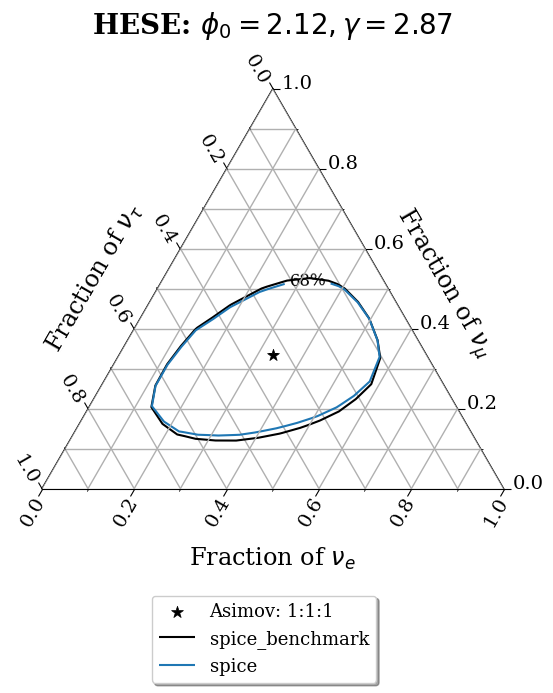

In [23]:
names = [
"spice_benchmark",
"spice",
]
labels = names
compare_contours( names = names,
                  labels = labels,
                  levels = ["68%"],
                  output_name = "compare_spice")

for name in names: compare_area( alt_key=name, base_key="spice_benchmark", levels=["68%"] )

/data/user/tvaneede/utils/Ternary.py:74: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.xaxis.grid(*args, **kwargs)
/tmp/ipykernel_3725359/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_3725359/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_3725359/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_3725359/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].g

Area ratio (ftp_benchmark / ftp_benchmark) at 68%: 1.0000
Area ratio (ftp / ftp_benchmark) at 68%: 0.9151


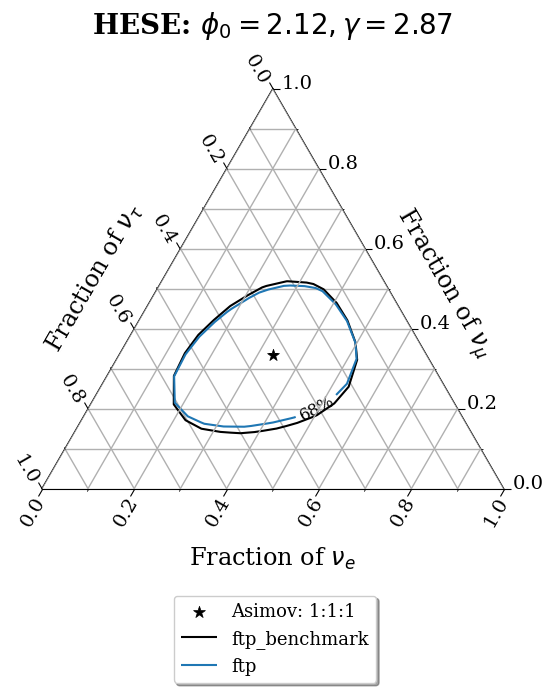

In [24]:
names = [
"ftp_benchmark",
"ftp",
]
labels = names
compare_contours( names = names,
                  labels = labels,
                  levels = ["68%"],
                  output_name = "compare_ftp")

for name in names: compare_area( alt_key=name, base_key="ftp_benchmark", levels=["68%"] )

/data/user/tvaneede/utils/Ternary.py:74: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.xaxis.grid(*args, **kwargs)
/tmp/ipykernel_3725359/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_3725359/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_3725359/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_3725359/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].g

Area ratio (ftp_benchmark / ftp_benchmark) at 68%: 1.0000
Area ratio (ftp / ftp_benchmark) at 68%: 0.9151


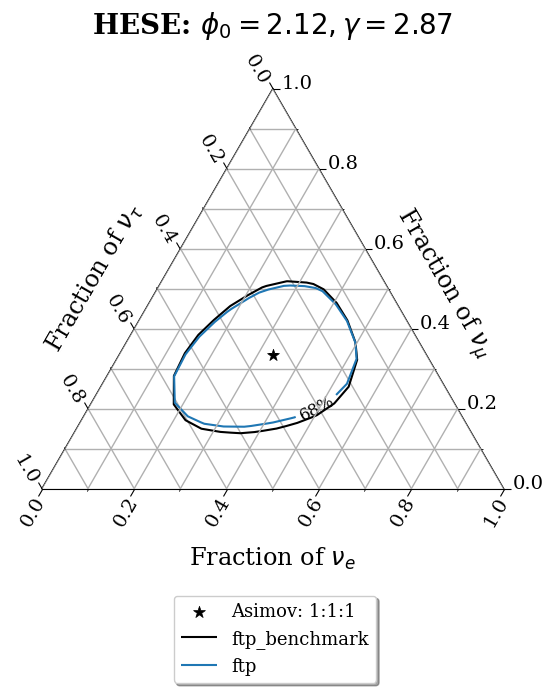

In [ ]:
names = [
"ftp_benchmark",
"ftp",
]
labels = names
compare_contours( names = names,
                  labels = labels,
                  levels = ["68%"],
                  output_name = "compare_ftp")

for name in names: compare_area( alt_key=name, base_key="ftp_benchmark", levels=["68%"] )